# PyTorch Computer Vision


## 0. Computer Vision Libraries In PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for cumputer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with and ML model.
* `torch.utils.data.Dataset` - Base dataset cllass for PyTorch
* `torch.utils.data.DataLoader` - Creates a Pytohn iterable over a dataset

In [68]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import requests 
from pathlib import Path
from helper_functions import accuracy_fn
from timeit import default_timer as timer
from tqdm.auto import tqdm
import random
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix



## 1. Getting a Dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets - 

https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html



In [2]:
# Setup training data

train_data = datasets.FashionMNIST(root= "data", # where to download data to?
                                    train= True, # do we want the treining dataset?
                                    download= True, # do we want to download it?
                                    transform = torchvision.transforms.ToTensor(), # how do we want to transform the data?
                                    target_transform=None # how do we want to transform the labels/targets?
                                   )

test_data = datasets.FashionMNIST(root="data",
                                  train= False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None
)

In [3]:
len(train_data),len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image,label


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
# Check the shape of our image
print(f'Image shape: {image.shape} -> [color channels, height, width]')
print(f"Image lalbel:{class_names [label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]
Image lalbel:Ankle boot


### 1.2 Visualizing  our  data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

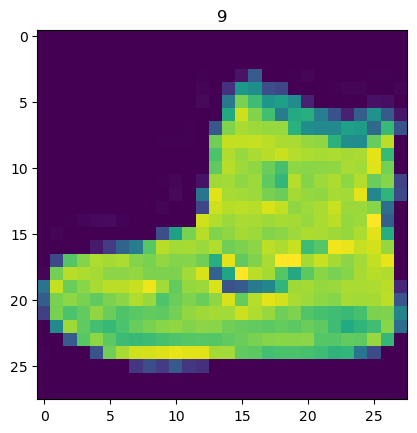

In [9]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

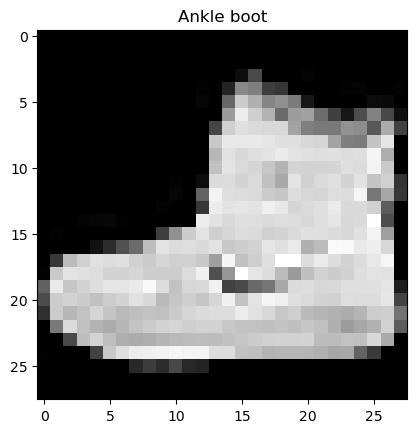

In [10]:
plt.imshow(image.squeeze(),cmap= "gray")
plt.title(class_names[label]);

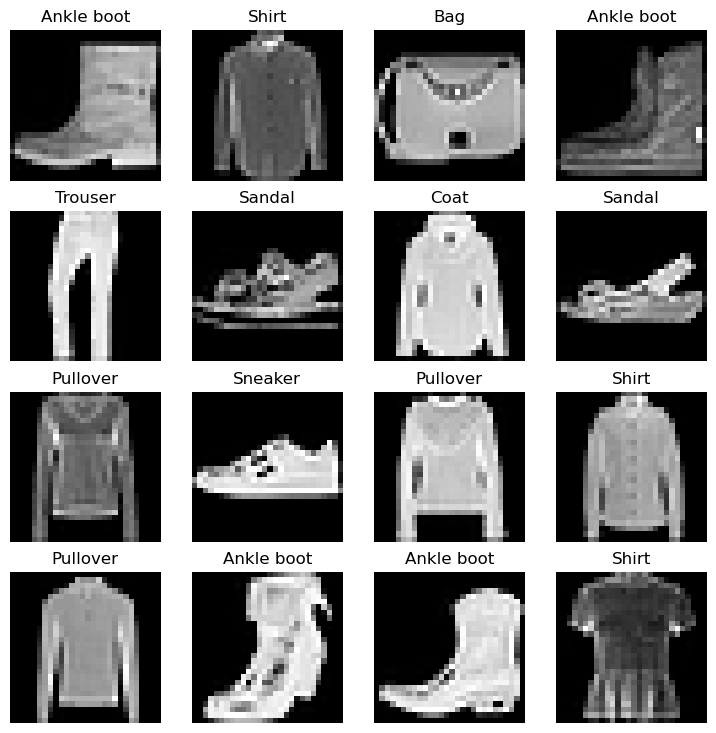

In [11]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0, len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non-linearities?

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our d ata into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch.

For more - https://www.youtube.com/watch?v=4qJaSmvhxi8

In [12]:
# Set up the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset= train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset= test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25b177a4950>,
 <torch.utils.data.dataloader.DataLoader at 0x25b10a44470>)

In [13]:
# Let's check out what've created
print(f"DataLoaders: {train_dataloader} {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}.....")
print(f"Length of test_trainloader: {len(test_dataloader)} batches of {BATCH_SIZE}..... ")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x0000025B177A4950> <torch.utils.data.dataloader.DataLoader object at 0x0000025B10A44470>
Length of train_dataloader: 1875 batches of 32.....
Length of test_trainloader: 313 batches of 32..... 


In [14]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))  
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


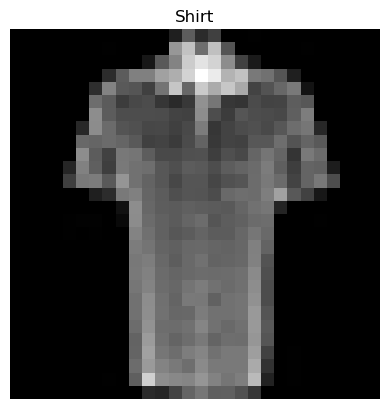

In [15]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap = "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model -: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best parctice to start with a baseline model

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [16]:
# Create a flatten layer 
flatten_model = nn.Flatten()

# Get a single sample 
x =  train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened 
print(f"Shape before flattening: {x.shape} -> [color channels, height, width]")
print(f'Shape after flatteninig: {output.shape} -> [color channels, height*width]')

Shape before flattening: torch.Size([1, 28, 28]) -> [color channels, height, width]
Shape after flatteninig: torch.Size([1, 784]) -> [color channels, height*width]


In [17]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int ):
        super().__init__()
        self.layer_stack =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [18]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # this is 28*28
                              hidden_units= 10, # how many units in the hidden layer
                              output_shape= len(class_names) # one for every class
                              ).to("cpu")

In [19]:
dummy_x = torch.rand(1,1,28,28)
model_0(dummy_x)

tensor([[ 0.2826,  0.0491, -0.0742, -0.1099, -0.0071,  0.1045, -0.3287,  0.0522,
          0.3119, -0.3001]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working woth multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric

In [20]:
# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file:
    print("helper_functions.py already exists, skipping download...")

else:
    print('Downloading helper_functions.py')
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py") as f:
        f.write(request.content)


helper_functions.py already exists, skipping download...


In [21]:
# Setup loss function and opimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [22]:
def print_train_time(start:float,end:float,device:torch.device=None):
    """Prints difference between start and end time."""
    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time,device="cpu")


Train time on cpu: 0.000 seconds


7.870000001730659e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

In [24]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

#Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches 
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y) # accumulate train loss
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss Backward
        loss.backward()
 
        # 5. Optimizer step
        optimizer.step()
    
    # Print out what's happening
        if batch % 100 == 0:
            print(f"Looked at {batch *len(X)}/{len(train_dataloader.dataset)} samples")

    # Divite total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with  torch.inference_mode():
        for X_test,y_test in test_dataloader:
            # 1. Forward pass
            test_pred= model_0(X_test)

            # 2. Calculate the loss (accumlatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate the accuracy 
            test_acc += accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)
    
    # Print out what's happening 
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_tim_model_0 = print_train_time(start= train_time_start_on_cpu,end= train_time_end_on_cpu,device=str(next(model_0.parameters()).device))    


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 3200/60000 samples
Looked at 6400/60000 samples
Looked at 9600/60000 samples
Looked at 12800/60000 samples
Looked at 16000/60000 samples
Looked at 19200/60000 samples
Looked at 22400/60000 samples
Looked at 25600/60000 samples
Looked at 28800/60000 samples
Looked at 32000/60000 samples
Looked at 35200/60000 samples
Looked at 38400/60000 samples
Looked at 41600/60000 samples
Looked at 44800/60000 samples
Looked at 48000/60000 samples
Looked at 51200/60000 samples
Looked at 54400/60000 samples
Looked at 57600/60000 samples


 33%|███▎      | 1/3 [00:09<00:18,  9.36s/it]


Train loss: 0.6355 | Test loss: 0.5304 | Test accuracy: 80.79073482428115
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 3200/60000 samples
Looked at 6400/60000 samples
Looked at 9600/60000 samples
Looked at 12800/60000 samples
Looked at 16000/60000 samples
Looked at 19200/60000 samples
Looked at 22400/60000 samples
Looked at 25600/60000 samples
Looked at 28800/60000 samples
Looked at 32000/60000 samples
Looked at 35200/60000 samples
Looked at 38400/60000 samples
Looked at 41600/60000 samples
Looked at 44800/60000 samples
Looked at 48000/60000 samples
Looked at 51200/60000 samples
Looked at 54400/60000 samples
Looked at 57600/60000 samples


 67%|██████▋   | 2/3 [00:17<00:08,  8.82s/it]


Train loss: 0.4999 | Test loss: 0.4911 | Test accuracy: 82.62779552715655
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 3200/60000 samples
Looked at 6400/60000 samples
Looked at 9600/60000 samples
Looked at 12800/60000 samples
Looked at 16000/60000 samples
Looked at 19200/60000 samples
Looked at 22400/60000 samples
Looked at 25600/60000 samples
Looked at 28800/60000 samples
Looked at 32000/60000 samples
Looked at 35200/60000 samples
Looked at 38400/60000 samples
Looked at 41600/60000 samples
Looked at 44800/60000 samples
Looked at 48000/60000 samples
Looked at 51200/60000 samples
Looked at 54400/60000 samples
Looked at 57600/60000 samples


100%|██████████| 3/3 [00:27<00:00,  9.04s/it]


Train loss: 0.4741 | Test loss: 0.4989 | Test accuracy: 82.85742811501598
Train time on cpu: 27.134 seconds


## 4. Make Predictions and get Model 0 results

In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """"Return a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # Make predictions
            y_pred = model_0(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss/= len(data_loader)
        acc/= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class 
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model= model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:01<00:00, 223.97it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.49889200925827026,
 'model_acc': 82.85742811501598}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [26]:
!nvidia-smi

Sun Sep 29 04:03:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   60C    P5             17W /   70W |     125MiB /   6144MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
torch.cuda.is_available()

True

In [28]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

 We learned about the power of non-linearity with notebook 02

In [29]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape: int, hidden_units:int,output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs to a single vector
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
            )
        
    def forward(self,x):
        return self.layer_stack(x)

In [30]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28*28 image goes in
                              hidden_units=10,
                              output_shape= len(class_names)).to(device) # send to the GPU if it's available

next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

In [31]:
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1) # tries to update our model's parameters to reduce the loss

### 6.2 Functionizng training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [32]:
def train_step(model: torch.nn.Module,data_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module, optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device ):
    ''''Performs a training with model trying to learn on data_loader.'''
    
    train_loss,train_acc = 0,0
    
    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches 
    for batch, (X,y) in enumerate(data_loader):
        # Put data on target device
        X,y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model (X) # outputs the raw logits of the model

        # 2. Calculate loss/accuracy (per batch)
        loss = loss_fn(y_pred, y) # accumulate train loss
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels    

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss Backward
        loss.backward()
 
        # 5. Optimizer step
        optimizer.step()
 

    # Divite total train loss by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")    

In [33]:
def test_step(model:torch.nn.Module,data_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module,accuracy_fn,device:torch.device = device):
    '''Performs as testing loop step on model going over dataloader.'''
    
    test_loss, test_acc = 0,0
    
    # Put the model in eval mode
    model.eval()

    # Turn on infrence mode context manager 
    with torch.inference_mode():
        for X,y in data_loader:
            # Send the data to the target device
            X,y = X.to(device), y.to(device)

            # 1. Forward pass 
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% ")


In [34]:
torch.manual_seed(42)

# Measure time 
train_time_start_on_gpu = timer()

# Set epochs 
epochs = 3

# Create a optimization and evaluation using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
    test_step(model=model_1,data_loader= test_dataloader, loss_fn= loss_fn,accuracy_fn=accuracy_fn,device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,end= train_time_end_on_gpu,device= device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train accuracy: 61.34%


 33%|███▎      | 1/3 [00:10<00:20, 10.09s/it]

Test loss: 0.95636 | Test acc: 65.00% 
Epoch: 1
----------
Train loss: 0.78101 | Train accuracy: 71.93%


 67%|██████▋   | 2/3 [00:20<00:10, 10.44s/it]

Test loss: 0.72227 | Test acc: 73.91% 
Epoch: 2
----------
Train loss: 0.67027 | Train accuracy: 75.94%


100%|██████████| 3/3 [00:28<00:00,  9.55s/it]

Test loss: 0.68500 | Test acc: 75.02% 
Train time on cuda: 28.653 seconds


**Note:** Sometimes, dpeending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
2. The hardware you're using has better CPU in terms compute capability than the GPU.
   
For more on how to make your models compute faster, see here:https://horace.io/brrr_intro.html

In [35]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.49889200925827026,
 'model_acc': 82.85742811501598}

In [36]:
total_train_tim_model_0

27.133913399999983

In [37]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """"Return a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # Make our data device agnostic
            X,y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss/= len(data_loader)
        acc/= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class 
            "model_loss": loss.item(),
            "model_acc": acc}




In [38]:
model_1_results = eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 399.86it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

## Model 2: Building  a Convolutional Neural Network (CNN)

CNN's are also known ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/

In [39]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinYVGG  model from CNN explainer website.
    """
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),# values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7 ,  # there's a trick to calculating this...
                      out_features=output_shape)
        )

    def forward(self,x):
        x= self.block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier: {x.shape}")
        return x

In [40]:
image.shape

torch.Size([1, 28, 28])

In [41]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,hidden_units=10, output_shape= len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

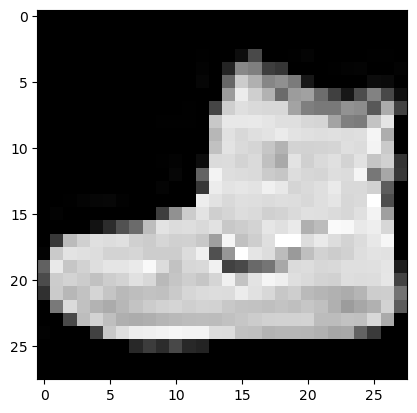

In [42]:
plt.imshow(image.squeeze(), cmap="gray")

In [43]:
# Pass image through the model
image = image.to(device)
model_2(image.unsqueeze(0))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for `nn.Conv2d()` here -  https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [45]:
torch.manual_seed(42)

# Create a batch of images 
images= torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [46]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer =nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)

# Pass the data through the convolutional layer
conv_output =conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d()`

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html


In [47]:
test_image.shape


torch.Size([3, 64, 64])

In [48]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}'")

# Create a sample nn.MaxPool2d layer 
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer 
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going thorugh conv_layer(): {test_image_through_conv.shape}")\

# Pass data through the max pool layer 
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going thorugh conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])'
Shape after going thorugh conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going thorugh conv_layer() and max_pool_layer(): torch.Size([1, 10, 32, 32])


In [49]:
torch.manual_seed(42)
# Create a random tensor with similar number of dimensions to our images
random_tensor =torch.randn(size=(1,1,2,2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer 
max_pool_tensor=max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}" )
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [50]:
# Setup loss functopn/eval metrics/optmizer
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params = model_2.parameters(),lr=0.1)

In [51]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

### 7.4 Training and testing `model_2` using our training and test functions

In [52]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

# Train and test model
epochs =3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model_2,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
    test_step(model=model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)

train_time_end_model_2=timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,end=train_time_end_model_2,device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.60798 | Train accuracy: 78.02%


 33%|███▎      | 1/3 [00:09<00:18,  9.22s/it]

Test loss: 0.40498 | Test acc: 85.60% 
Epoch: 1
-------
Train loss: 0.35899 | Train accuracy: 87.02%


 67%|██████▋   | 2/3 [00:18<00:09,  9.21s/it]

Test loss: 0.35089 | Test acc: 87.25% 
Epoch: 2
-------
Train loss: 0.32174 | Train accuracy: 88.36%


100%|██████████| 3/3 [00:28<00:00,  9.65s/it]

Test loss: 0.32761 | Test acc: 88.07% 
Train time on cuda: 28.958 seconds


In [53]:
# Get model_2 results
model_2_results= eval_model(model=model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)
model_2_results

100%|██████████| 313/313 [00:00<00:00, 368.77it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3276131749153137,
 'model_acc': 88.06908945686901}

## 8. Compare model results and training time


In [54]:
compare_results = pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.498892,82.857428
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.327613,88.069089


In [55]:
# Add training time to results comparison
compare_results["training_time"]=[total_train_tim_model_0,total_train_time_model_1,total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.498892,82.857428,27.133913
1,FashionMNISTModelV1,0.685001,75.019968,28.653434
2,FashionMNISTModelV2,0.327613,88.069089,28.958184


Text(0, 0.5, 'model')

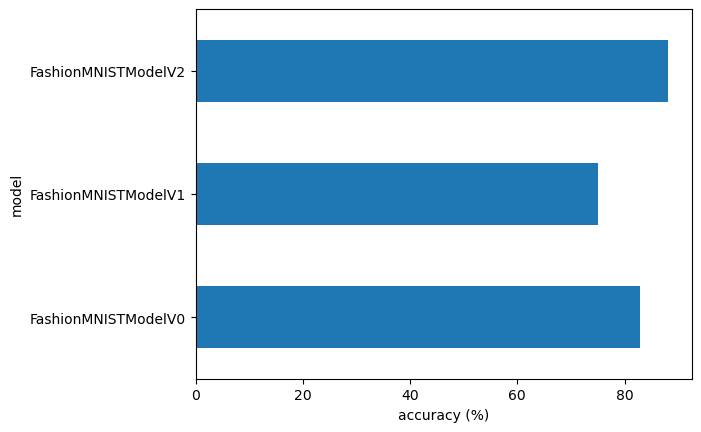

In [56]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions with best model

In [57]:
def make_predictions(model:torch.nn.Module,data:list,device:torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #Prepare the sample
            sample = torch.unsqueeze(sample,dim=0).to(device)
           
            # Forward pass (model outputs raw logit) \
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob= torch.softmax(pred_logit.squeeze(),dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

# Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [58]:
random.seed(42)
test_samples= []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

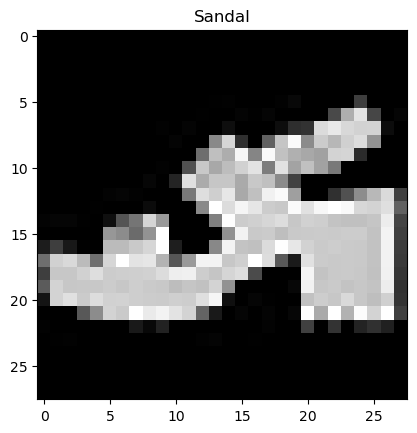

In [59]:
plt.imshow(test_samples[0].squeeze(),cmap="gray") 
plt.title(class_names[test_labels[0]])

In [60]:
# Make predictions 
pred_probs = make_predictions(model=model_2,data=test_samples)

# View first two prediction probabilites
pred_probs[:2]

tensor([[3.1261e-07, 8.2553e-09, 3.8518e-08, 5.2758e-08, 4.0067e-08, 9.9981e-01,
         1.4124e-06, 7.1765e-06, 4.7120e-05, 1.3404e-04],
        [7.7665e-02, 4.4518e-01, 3.8610e-03, 5.9483e-02, 3.0272e-01, 2.1765e-04,
         1.0970e-01, 1.4961e-04, 9.6197e-04, 6.9929e-05]])

In [61]:
# Conver prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 9, 4, 3, 0, 4, 7, 1])

In [62]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

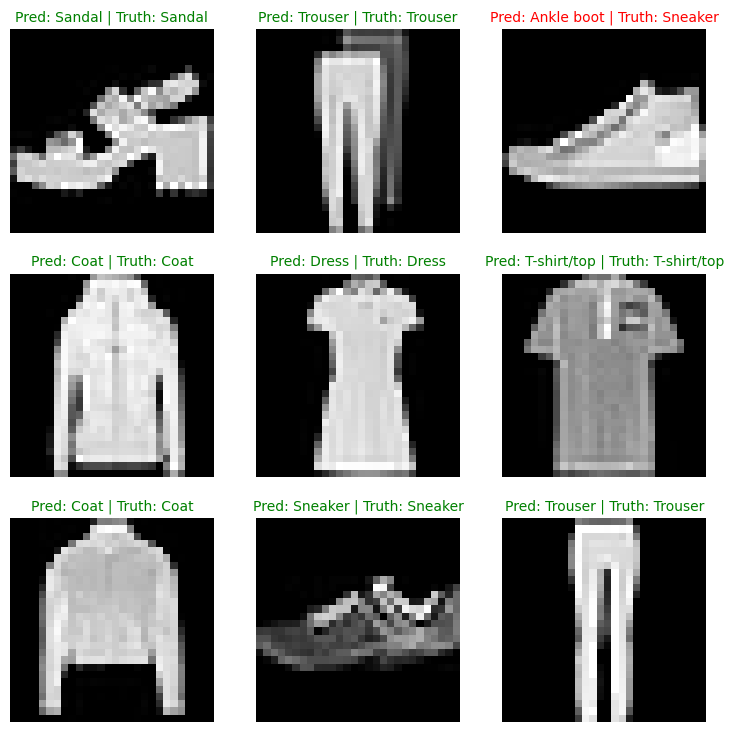

In [63]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows= 3
ncols=3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows,ncols,i+1) 

    # Plot the target image
    plt.imshow(sample.squeeze(),cmap="gray")

    # Find the prediction (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text= f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text,fontsize=10,c="g") # green text if prediction same as truth 
    else:
        plt.title(title_text,fontsize=10,c="r")

    plt.axis(False);

## 10. Making a confusion matrix for futher prediction evaluation

A confusıon matrix is a fantastic way of evaluating your classification models visually: 

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix` - https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` - https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [66]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)

        # Do the forwawrd pass
        y_logit = model_2(X)

        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)

        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
print(y_preds)
y_pred_tensor = torch.cat(y_preds,dim=0)
y_pred_tensor[:10]

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 266.50it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 7, 7, 5,
        1, 6, 6, 0, 9, 4, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 4, 6, 6, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 8]), tensor([6, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 9, 9, 4, 2, 5, 7, 6, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 7, 4, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 6, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([8, 2, 3, 8, 0, 9, 2, 7, 4, 2, 6, 5, 4, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 8,
        7, 9, 8, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 6, 9, 2, 2, 8, 6, 4,
        6, 4, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4,
       

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

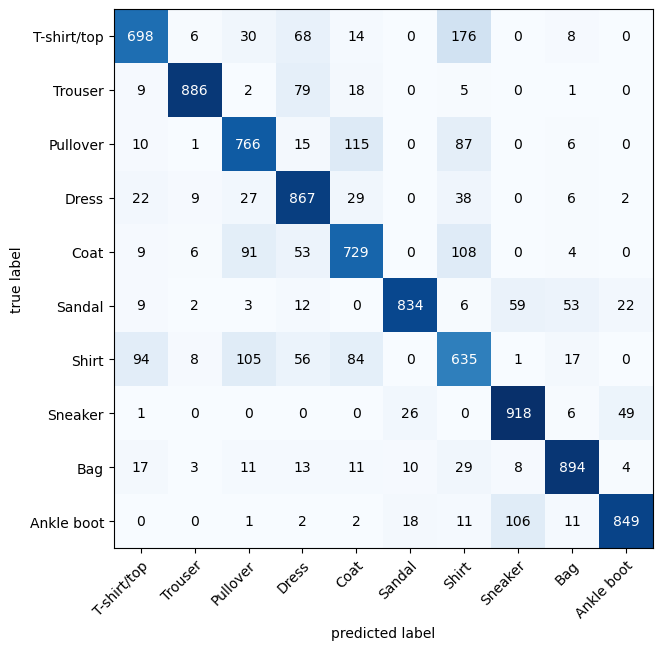

In [71]:
# 2. Setup confusion instance and compare predictions to targets 
confmat = ConfusionMatrix(num_classes = len(class_names),task="multiclass")
confmat_tensor = confmat(preds = y_pred_tensor ,target = test_data.targets)

# 3, Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat= confmat_tensor.numpy(), # Matplotlib likes working with numpy
                                class_names= class_names,
                                figsize = (10,7))                                

## 11. Save and load best performing model 

In [76]:
# Create model directorcy part 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok= True)

# Create model savepath
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),f = MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [77]:
# Create a new instance 
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)


C:\Users\Caner\AppData\Local\Temp\ipykernel_22580\1597914161.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [78]:
# Evaluate loaded model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

loaded_model_2_results

100%|██████████| 313/313 [00:01<00:00, 251.11it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3276131749153137,
 'model_acc': 88.06908945686901}

In [79]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)